# AWESim SOSS

**Analyzing Webb Exoplanet Simulations with SOSS**

In [4]:
# Magic functions
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Imports
import os
import pickle
import batman
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import AWESim_SOSS
import astropy.units as q
import astropy.constants as ac
from matplotlib.colors import LogNorm
from sklearn.externals import joblib
from ExoCTK import svo
from ExoCTK import core
from AWESim_SOSS.sim2D import awesim

In [6]:
# Get the subpackage directory
pkg_path = os.path.dirname(AWESim_SOSS.__file__)
print(pkg_path)

# Set the location of your model grid FITS files
try:
    model_dir = os.environ['MODELGRID_DIR']
except:
    model_dir = '/your/path/here/'

print(model_dir)

/Users/jfilippazzo/Documents/Modules/AWESim_SOSS/AWESim_SOSS
/user/jfilippazzo/Models/ACES/default/


In [8]:
# Get the K-band filter (for scaling of our input 1D spectra)
K = svo.Filter('2MASS.Ks')

## Late-M Dwarf TSO

Here is how to generate time series observations of a brown dwarf (or any other isolated star with no transiting planet).

We need two components to generate this simulation:
- A flux calibrated stellar spectrum
- A time axis for each frame of the TSO

We will pull a model spectrum for our desired object from the Phoenix ACES library and flux calibrate it so that it has a 9.3 K-band magnitude.

In [9]:
# BD spectrum from model grid @ mu=1
teff, logg, feh = 3550, 5, 0
model_grid = core.ModelGrid(os.environ['MODELGRID_DIR'], Teff_rng=(3500,3600), logg_rng=(5,5.5), FeH_rng=(0,0.5), wave_rng=(0.5,2.8), resolution=700)
star = model_grid.get(teff, logg, feh)
wave_s_raw, flux_s_raw = star['wave'], star['flux'][-1]

1056 models loaded from /user/jfilippazzo/Models/ACES/default/
8/1056 spectra in parameter range Teff: (3500, 3600) , logg: (5, 5.5) , FeH: (0, 0.5) , wavelength: (0.5, 2.8)
Loading flux into table...
100.00 percent complete!
Interpolating grid point [3550/5/0]...
Run time in seconds:  13.445390939712524


Now let's scale it from the stellar surface (which is just the model grid output) to our desired K magnitude.

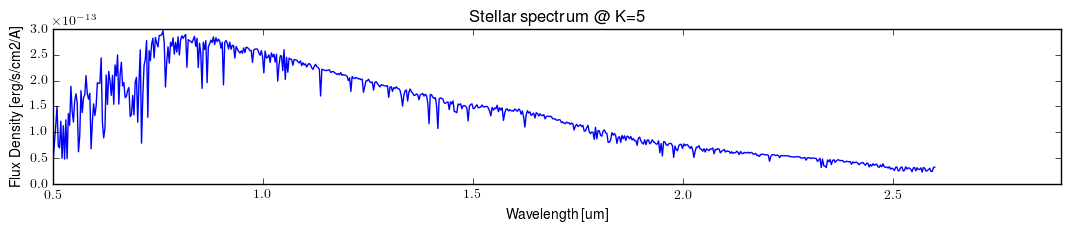

In [10]:
# Scale by K magnitude
Kmag = 5
wave_s, flux_s, *_ = awesim.norm_to_mag([wave_s_raw*q.um,flux_s_raw*q.erg/q.s/q.cm**2/q.AA], Kmag, K)
Mdwarf = [wave_s, flux_s]

# Plot it 
plt.figure(figsize=(13,2));
plt.plot(*Mdwarf);
plt.xlim(0.5,2.9);
plt.title('Stellar spectrum @ K={}'.format(Kmag));
plt.ylabel('Flux Density [erg/s/cm2/A]');
plt.xlabel('Wavelength [um]');

Since there is no planet involved, we only need the stellar spectrum and the time axis to generate the simulation.

In [23]:
# Initialize the simulation
ngrps, nints = 3, 100
TSO1 = awesim.TSO(ngrps, nints, Mdwarf)

In [26]:
# Now run it
TSO1.run_simulation()

Calculating order 1 light curves...


NameError: name 'local_ld_coeffs' is not defined

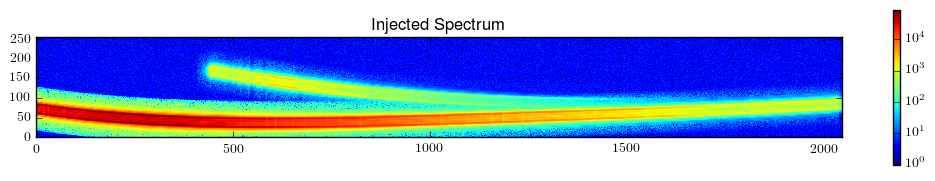

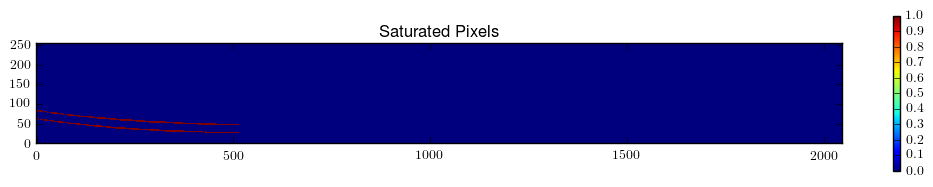

In [17]:
# Take a look
TSO1.plot_frame()
TSO1.plot_saturation()

## G 240-52 (M4)

This uses actual data, though there are gaps.

In [ ]:
# Get the raw data
wave_s_raw, flux_s_raw = np.genfromtxt(pkg_path+'/files/m4v_combined_template.txt', unpack=True)

# Scale by K magnitude
Kmag = 9.128 # From SIMBAD
wave_s, flux_s, *_ = awesim.norm_to_mag([wave_s_raw*q.um,flux_s_raw*q.erg/q.s/q.cm**2/q.AA], Kmag, K)
M4 = [wave_s, flux_s]

# Plot it 
plt.figure(figsize=(13,2))
plt.plot(*M4)
plt.xlim(0.5,2.9)
plt.title('Stellar spectrum @ K={}'.format(Kmag))
plt.ylabel('Flux Density [erg/s/cm2/A]')
plt.xlabel('Wavelength [um]')

In [ ]:
# Initialize and run the simulation
TSO2 = awesim.TSO(bjd, M4)
TSO2.run_simulation()

In [ ]:
# Take a look!
TSO2.plot_frame()

## WASP-107 TSO (without planet)

In [ ]:
# Stellar spectrum from model grid @ mu=1
teff, logg, feh = 4430, 4.51, 0.02
model_grid = core.ModelGrid(os.environ['MODELGRID_DIR'], Teff_rng=(4400,4500), logg_rng=(4.5,5), FeH_rng=(0,0.5), wave_rng=(0.5,2.8), resolution=700)
star = model_grid.get(teff, logg, feh)
wave_s_raw, flux_s_raw = star['wave'], star['flux'][-1]

In [ ]:
# Scale by K magnitude
Kmag = 8.637 # From SIMBAD
wave_s, flux_s, *_ = awesim.norm_to_mag([wave_s_raw*q.um,flux_s_raw*q.erg/q.s/q.cm**2/q.AA], Kmag, K)
WASP107 = [wave_s, flux_s]

# Plot it 
plt.figure(figsize=(13,2))
plt.plot(*WASP107)
plt.xlim(0.5,2.9)
plt.title('Stellar spectrum @ K={}'.format(Kmag))
plt.ylabel('Flux Density [erg/s/cm2/A]')
plt.xlabel('Wavelength [um]')

In [ ]:
# Initialize and run the simulation
TSO3 = awesim.TSO(bjd, WASP107, extend=100)
TSO3.run_simulation()

In [ ]:
TSO3.plot_frame()

In [ ]:
joblib.dump(dict(waves=WASP107[0], flux=WASP107[1]), 'wasp107_injection_spectrum.save')

## WASP 107 TSO (with planet)

We need five components to generate a transiting exoplanet:
- A flux calibrated stellar spectrum
- A time axis for each frame of the TSO
- A transmission spectrum of the planet
- A map of the limb darkening coefficients at each pixel
- The orbital parameters of the planet

We have the stellar spectrum from above so let's get the planetary transmission spectrum (generated with Exotransmit).

In [ ]:
# Get the forward model planet spectrum generated by Matt...
WASP107b = np.genfromtxt(pkg_path+'/files/WASP107b_pandexo_input_spectrum.dat', unpack=True)

# Plot it
plt.plot(*WASP107b)
plt.xlim(0.5,2.9)
plt.title('Planetary Transmission Spectrum @ mu=1')
plt.ylabel('Rp/R*')
plt.xlabel('Wavelength [um]')

Now we must calaulate a map of the limb darkening coefficients for the star through the GR700XD filter. This takes a few minutes so I precomputed and saved the values.

In [ ]:
# Specify the limb darkening profile
profile = 'quadratic'

# # ================================================================================================================================================
# # Get the GR700XD filter throughput
# filt = os.path.join(os.path.join(os.path.dirname(core.__file__),'AWESim_SOSS/data/filters/NIRISS.GR700XD.1.txt'))
# GR700XD = svo.Filter('GR700XD', np.genfromtxt(filt, unpack=True), n_bins=85, wl_min=0.8*q.um, wl_max=2.5*q.um)
# GR700XD.plot()
# GR700XD.info()

# Calculate the limb darkening coefficients for 85 bins between 0.8 and 2.5um
# savepath = '/Users/jfilippazzo/Desktop/WASP107_LDC.txt'
# ldcs = lf.ldc(teff, logg, feh, model_grid, ['quadratic'], bandpass=GR700XD, grid_point=star.copy(), mu_min=0.08, save=savepath)

# GR700XD_WL = svo.Filter('GR700XD', np.genfromtxt(filt, unpack=True), n_bins=1, wl_min=0.8*q.um, wl_max=2.5*q.um)
# ldcs_WL = lf.ldc(teff, logg, feh, model_grid, ['quadratic'], bandpass=GR700XD_WL, grid_point=star.copy(), mu_min=0.08, save=savepath.replace('.txt','_WL.txt'), plot=True)

# w0, c1, e1, c2, e2 = list(zip(*ldcs['quadratic']['coeffs']))
# plt.scatter(c1, c2, c=w0, cmap='viridis')
# plt.colorbar()
# w0, c1, e1, c2, e2 = list(zip(*ldcs_WL['quadratic']['coeffs']))
# plt.scatter(c1[0], c2[0], c='r', s=50, zorder=10)
# plt.xlabel('c1')
# plt.ylabel('c2')

# Generate the coefficient wave map
# ld_coeffs_lookup = spec2D.ld_coefficient_lookup(lam1, profile, star, model_grid)
# coeff_map = spec2D.ld_coefficients(lam1, ld_coeffs_lookup)
# np.save('AWESim_SOSS/{}_ldc_map.npy'.format(profile), coeff_map)
# # ================================================================================================================================================

# Get the LDC map from file
ld_coeffs = joblib.load(pkg_path+'/files/{}_ldc_map.save'.format(profile))

Now let's use Batman to set the orbital paramaters.

In [ ]:
# Set the wavelength independent orbital parameters
params = batman.TransitParams()
params.t0 = 0.                                # time of inferior conjunction
params.per = 5.7214742                        # orbital period
params.a = 0.0558*q.AU.to(ac.R_sun)*0.66      # semi-major axis (in units of stellar radii)
params.inc = 89.8                             # orbital inclination (in degrees)
params.ecc = 0.                               # eccentricity
params.w = 90.                                # longitude of periastron (in degrees)

# Test it
params.limb_dark = 'quadratic'
params.u = ld_coeffs[5]
params.rp = (0.94*ac.R_jup.to(ac.R_sun)*0.66).value

# Generate the light curve for this pixel
m = batman.TransitModel(params, bjd) 
lc = m.light_curve(params)

plt.plot(bjd, lc)
plt.ylim(0.995,1.0005)

Now we can run the simulator.

In [ ]:
# Create TSO object
TSO4 = awesim.TSO(bjd, WASP107, WASP107b, params, ld_coeffs)

In [ ]:
TSO4.compute_light_curve_order(orders=[1,2])

In [ ]:
TSO4.plot_frame()

In [ ]:
TSO4.plot_lightcurve([15,300,500])

In [ ]:
TSO4.plot_slice([15,300,500])

In [ ]:
TSO4.save_tso() # saves to file "dummy.save"